# Open Food Facts: The Free Food Products Database
## Nutrition Regression

## Introduction
Our practicum team (Anna, Ariq, Jasmine, Lisa) is working on helping CSAA with a project about food supply chain and food insecurity. We're building a food supply chain tracking mechanism and a data warehouse for the project, so we needed a dataset with nutritional facts for fruits and vegetables and incidentally we found this dataset.


## Dataset
Open Food Facts is a free, open, collbarative database of food products from around the world, with ingredients, allergens, nutrition facts and all the tidbits of information we can find on product labels. Google used this dataset for their Summer of Code event.

Open Food Facts is a non-profit association of volunteers. 5000+ contributors like you have added 100 000+ products from 150 countries using our Android, iPhone or Windows Phone app or their camera to scan barcodes and upload pictures of products and their labels.

## Data Dictionary
Available at https://www.kaggle.com/openfoodfacts/world-food-facts

## Table of Contents
1. Data Cleaning
2. EDA
3. Modeling - Linear Regression
4. Validation

In [1]:
# importing packages
import pandas as pd
from math import pi
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud, STOPWORDS
from scipy.stats.stats import pearsonr
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None # Warning for chained copies disabled

In [2]:
# reading data
df = pd.read_csv('en.openfoodfacts.org.products.tsv', low_memory=False, sep='\t')
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# checking nulls
df.isnull().sum()

code                                        26
url                                         26
creator                                      3
created_t                                    3
created_datetime                            10
last_modified_t                              0
last_modified_datetime                       0
product_name                             17512
generic_name                            298313
quantity                                236742
packaging                               266067
packaging_tags                          266068
brands                                   29050
brands_tags                              29070
categories                              252728
categories_tags                         252752
categories_en                           252726
origins                                 330977
origins_tags                            331015
manufacturing_places                    314019
manufacturing_places_tags               314026
labels       

### Data Cleaning

#### 1.1 Empty rows and columnns

Let's remove columns that have a high percentage of missing values.

In [4]:
# writing function
def filling_factor(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (df.shape[0]-missing_df['missing_count'])/df.shape[0]*100
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
    return missing_df
#____________________________________
missing_df = filling_factor(df)
missing_df[missing_df['filling_factor'] == 0]

,column_name,missing_count,filling_factor
0,water-hardness_100g,356027,0.0
1,ingredients_from_palm_oil,356027,0.0
2,ingredients_that_may_be_from_palm_oil,356027,0.0
3,nutrition_grade_uk,356027,0.0
4,-nervonic-acid_100g,356027,0.0
5,-erucic-acid_100g,356027,0.0
6,-mead-acid_100g,356027,0.0
7,-elaidic-acid_100g,356027,0.0
8,-butyric-acid_100g,356027,0.0
9,-caproic-acid_100g,356027,0.0


In [5]:
# drop columns that do not contain any values
df = df.dropna(axis = 1, how = 'all')
df.shape

(356027, 147)

The EDA will be focused on nutrition. This information is contained in the variables with the '100g' suffix. We will discard the products where at least one of these columns contain some information:

In [6]:
# looking at empty rows
# writing function
composant = []
for s in df.columns:
    if '_100g' in s: composant.append(s)
df_subset_columns = df[composant]
print('empty _100g raws: {}'.format(df_subset_columns.isnull().all(axis=1).sum()))
#___________________
# and deleting them
df_new = df[df_subset_columns.notnull().any(axis=1)]

empty _100g raws: 55904


#### 1.2 Redundant variables

In [7]:
list_columns = ['categories', 'categories_tags', 'categories_en']
df_new[df_new[list_columns].notnull().any(axis=1)][['product_name']+ list_columns][:20:3]

,product_name,categories,categories_tags,categories_en
176,Salade Cesar,Légumes-feuilles,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
183,Pain Burger Artisan,Boulange,fr:boulange,fr:Boulange
188,Pâté au poulet,Poulets cuisinés,"en:meats,en:poultries,en:chickens,en:cooked-ch...","Meats,Poultries,Chickens,Cooked chicken"
199,Côtes du Rhône Villages 2014,"Boissons,Boissons alcoolisées,Vins,Vins frança...","en:beverages,en:alcoholic-beverages,en:wines,e...","Beverages,Alcoholic beverages,Wines,French win..."
228,Luxury Christmas Pudding,"Sugary snacks,Desserts,Biscuits and cakes,Cake...","en:sugary-snacks,en:biscuits-and-cakes,en:dess...","Sugary snacks,Biscuits and cakes,Desserts,Cake..."
238,Blle Pet 50CL Coca Cola Cherry,en:beverages,"en:beverages,en:sugared-beverages","Beverages,Sugared beverages"
249,7Up,"Sodas au citron,Boissons sucrées","en:plant-based-foods-and-beverages,en:beverage...","Plant-based foods and beverages,Beverages,Plan..."


This short listing shows that there is some redundancy in the information: The categories_tags and categories_en seem similar in their content except for the en: prefix that has been removed from keywords in the second column.

Hence, in case a column exists with the _en suffix, I decide to delete all the columns without any suffix or ending with the _tags string:

In [8]:
columns_to_remove = []
for s in df_new.columns:
    if "_en" in s: 
        t = s.replace('_en', '')
        u = s.replace('_en', '_tags')
        print("{:<20} 'no suffix' -> {} ; '_tags' suffix -> {}".format(s,
                                t in df_new.columns, u in df_new.columns))
        if t in df_new.columns: columns_to_remove.append(t)
        if u in df_new.columns: columns_to_remove.append(u)
df_new.drop(columns_to_remove, axis = 1, inplace = True)

categories_en        'no suffix' -> True ; '_tags' suffix -> True
labels_en            'no suffix' -> True ; '_tags' suffix -> True
countries_en         'no suffix' -> True ; '_tags' suffix -> True
allergens_en         'no suffix' -> True ; '_tags' suffix -> False
traces_en            'no suffix' -> True ; '_tags' suffix -> True
additives_en         'no suffix' -> True ; '_tags' suffix -> True
states_en            'no suffix' -> True ; '_tags' suffix -> True
main_category_en     'no suffix' -> True ; '_tags' suffix -> False


#### 1.3 Fix names in Countries

In this list, a few countries were not correctly translated from other languages (i.e. French) or do not correspond to a valid database entry. A list of official country names is available on wikipedia.

In [9]:
def count_words(df, colonne = 'categories_en'):
    list_words = set()
    for word in df[colonne].str.split(','):
        if isinstance(word, float): continue
        list_words = set().union(word, list_words)       
    print("Nb of categories in '{}': {}".format(colonne, len(list_words)))
    return list(list_words)
list_countries = count_words(df, 'countries_en')

Nb of categories in 'countries_en': 224


In [10]:
country_replacement = {'Tunisie': 'Tunisia', 'Niederlande': 'Netherland', 
    'fr:Bourgogne-aube-nogent-sur-seine':'France', 'fr:Sverige': 'Sweden', 
    'Vereinigtes-konigreich': 'United Kingdom',  'fr:Suiza':'Switzerland',
    'fr:Kamerun':'Cameroon', 'Other-japon':'Japon', 'fr:Marokko':'Morocco', 
    'ar:Tunisie':'Tunisia', 'fr:Marseille-5':'France', 'Australie':'Australia',
    'fr:Marseille-6':'France', 'fr:Scotland':'United Kingdom', 'Soviet Union':'Russia',
    'fr:Vereinigte-staaten-von-amerika':'United States', 'fr:Neukaledonien':'France',
    'fr:Nederland':'Netherland', 'Mayotte':'France', 'Spanje':'Spain', 'Frankrijk':'France',
    'Suisse':'Switzerland', 'fr:Belgie':'Belgium', 'Other-turquie':'Turkey',
    'fr:Spanien':'Spain', 'Pays-bas':'Netherland', 'fr:Saudi-arabien':'Saudi Arabia',
    'Virgin Islands of the United States':'United States', 'fr:England':'England',
    'Allemagne':'Germany', 'fr:Vereinigtes-konigreich':'United Kingdom', 'Belgique':'Belgium',
    'United-states-of-america':'United States', 'Réunion':'France', 'Martinique':'France',
    'Guadeloupe':'France','French Guiana':'France', 'Czech':'Czech Republic', 'Quebec':'Canada',
    'fr:Quebec':'Canada', 'fr:Deutschland':'Germany', 'Saint Pierre and Miquelon':'France'}

In [11]:
# replace the incorrect entries in the dataframe
for index, countries in df['countries_en'].str.split(',').items():
    if isinstance(countries, float): continue
    country_name = []
    found = False
    for s in countries:
        if s in country_replacement.keys():
            found = True
            country_name.append(country_replacement[s])
        else:
            country_name.append(s)
    if found:
        df.loc[index, 'countries_en'] = ','.join(country_name)    

In [12]:
list_countries = count_words(df, 'countries_en')

Nb of categories in 'countries_en': 206


In [13]:
# count country frequency 
country_count = dict()
for country in list(list_countries):
    country_count[country] = df['countries_en'].str.contains(country).sum()

Country Map Plot

In [14]:
data = dict(type='choropleth',
locations = list(country_count.keys()),
locationmode = 'country names', z = list(country_count.values()),
text = list(country_count.keys()), colorbar = {'title':'Product nb.'},
colorscale=[[0.00, 'rgb(204,255,229)'], [0.01, 'rgb(51,160,44)'],
            [0.02, 'rgb(102,178,255)'], [0.03, 'rgb(166,206,227)'],
            [0.05, 'rgb(31,120,180)'], [0.10, 'rgb(251,154,153)'],
            [0.20, 'rgb(255,255,0)'], [1, 'rgb(227,26,28)']])
layout = dict(title='Availability of products per country',
geo = dict(showframe = True, projection={'type':'Mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

#### 1.4 What are the key categories in this food dataset?

In [15]:
category_keys = count_words(df_new, 'categories_en')

Nb of categories in 'categories_en': 13328


In [16]:
count_keyword = dict()
for index, col in df_new['categories_en'].iteritems():
    if isinstance(col, float): continue
    for s in col.split(','):
        if s in count_keyword.keys():
            count_keyword[s] += 1
        else:
            count_keyword[s] = 1

keyword_census = []
for k,v in count_keyword.items():
    keyword_census.append([k,v])
keyword_census.sort(key = lambda x:x[1], reverse = True)

In [17]:
keyword_census[:5]

[['Plant-based foods and beverages', 25323],
 ['Plant-based foods', 21290],
 ['Beverages', 13790],
 ['Sugary snacks', 12188],
 ['Dairies', 10022]]

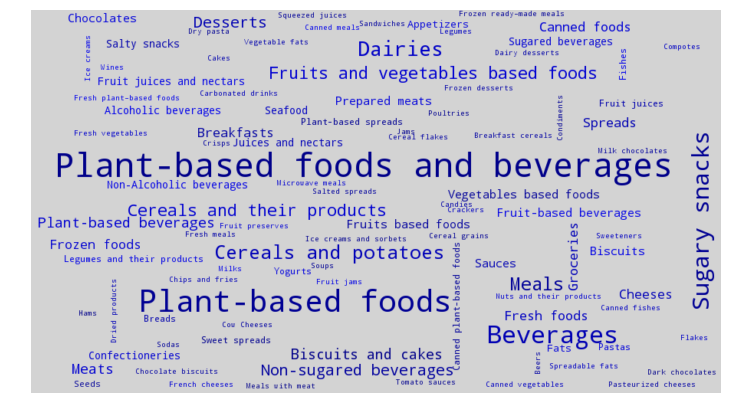

In [18]:
#_____________________________________________
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(11,9))
ax1 = fig.add_subplot(1,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_census[0:100]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 170.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=900,height=500, background_color='lightgray', 
                      max_words=1628,relative_scaling=0.6,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
plt.show()

In [19]:
#pick a category to focus on
pnns_group1_keys = count_words(df_new, 'pnns_groups_1')  
pnns_group2_keys = count_words(df_new, 'pnns_groups_2')  

Nb of categories in 'pnns_groups_1': 14
Nb of categories in 'pnns_groups_2': 42


In [20]:
#pick pnns groups 1
pnns_group1_keys

['Cereals and potatoes',
 'Sugary snacks',
 'Fruits and vegetables',
 'sugary-snacks',
 'Salty snacks',
 'Fat and sauces',
 'Composite foods',
 'unknown',
 'cereals-and-potatoes',
 'Milk and dairy products',
 'Fish Meat Eggs',
 'fruits-and-vegetables',
 'salty-snacks',
 'Beverages']

In [21]:
corresp = dict()
corresp['cereals-and-potatoes']  = 'Cereals and potatoes'
corresp['fruits-and-vegetables'] = 'Fruits and vegetables'
corresp['sugary-snacks'] = 'Sugary snacks'
corresp['salty-snacks'] = 'Salty snacks'

In [22]:
df_new['pnns_groups_1'] = df_new['pnns_groups_1'].replace(corresp)
pnns_group1_keys = count_words(df_new, 'pnns_groups_1')
pnns_group1_keys

Nb of categories in 'pnns_groups_1': 10


['Cereals and potatoes',
 'Sugary snacks',
 'Fruits and vegetables',
 'Salty snacks',
 'Fat and sauces',
 'Composite foods',
 'unknown',
 'Milk and dairy products',
 'Fish Meat Eggs',
 'Beverages']

In [23]:
col_filling = filling_factor(df_new)

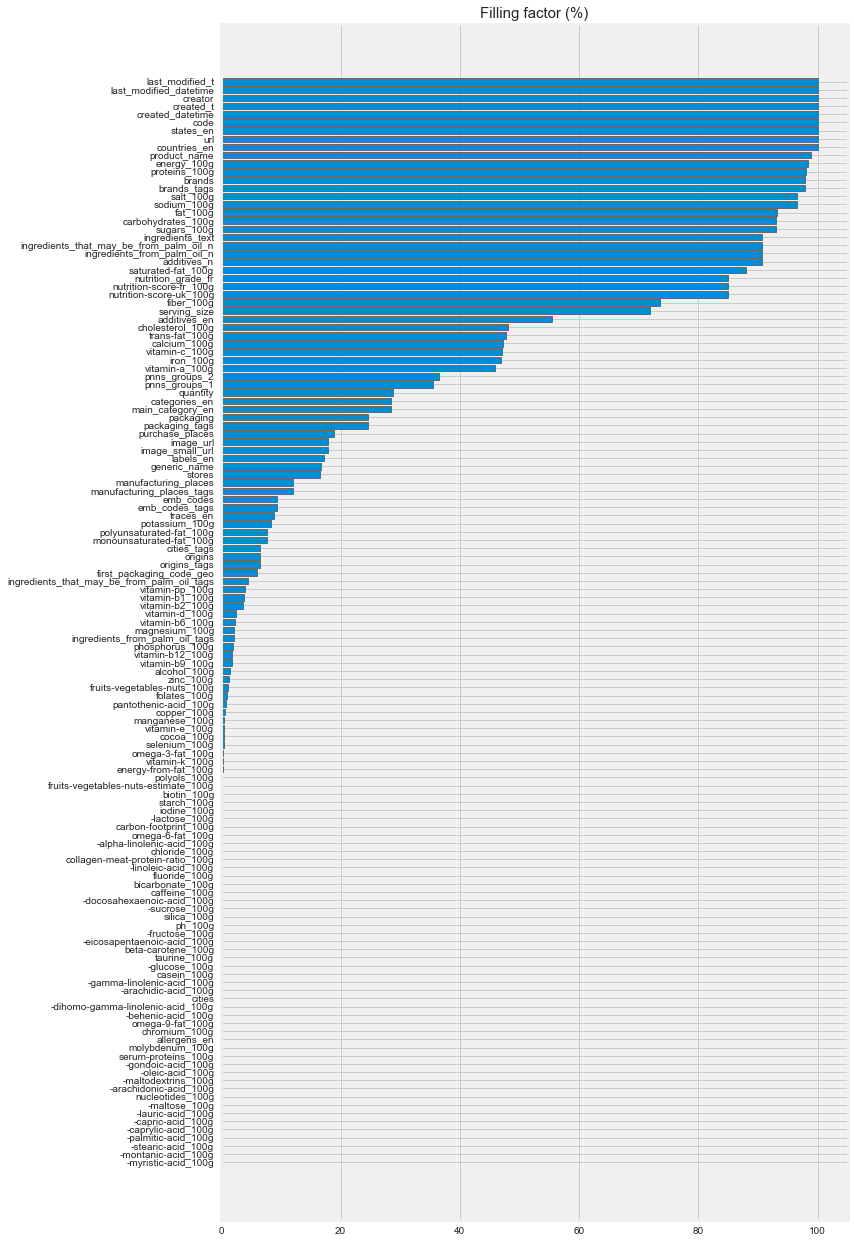

In [24]:
y_axis  = list(col_filling['filling_factor'])
x_axis  = [i for i in range(len(col_filling))]
x_label = list(col_filling['column_name'])
fig = plt.figure(figsize=(10, 22))
plt.yticks(x_axis, x_label)
plt.title('Filling factor (%)', fontsize = 15)
plt.barh(x_axis, y_axis)
plt.show()

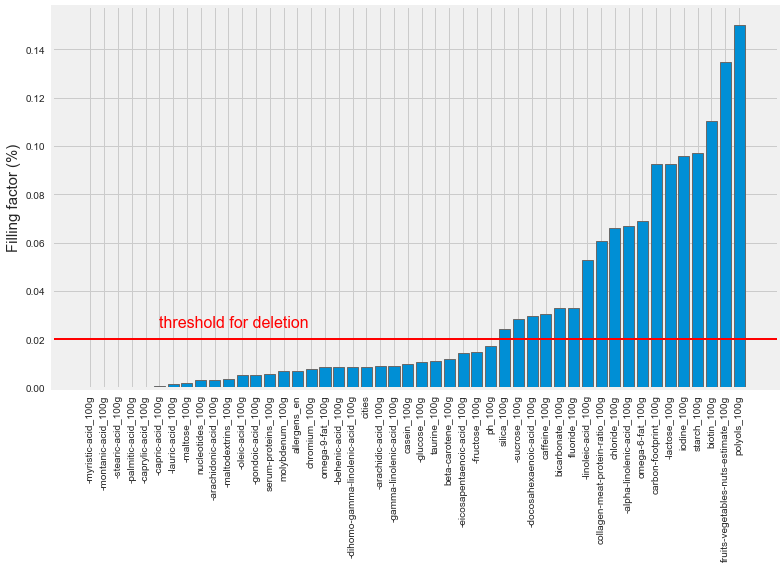

In [25]:
col_filling_2 = col_filling.loc[col_filling['filling_factor'] < 0.2]
y_axis  = list(col_filling_2['filling_factor'])
x_axis  = [i for i in range(len(col_filling_2))]
x_label = list(col_filling_2['column_name'])
fig = plt.figure(figsize=(11, 8))
plt.xticks(rotation=90)
plt.xticks(x_axis, x_label)
plt.ylabel('Filling factor (%)', fontsize = 15)
plt.bar(x_axis, y_axis)
plt.axhline(y=0.02, linewidth=2, color = 'r')
plt.text(5, 0.025, 'threshold for deletion', fontsize = 16, color = 'r')
plt.tight_layout()
plt.show()

From these graphs, we can see that many variables do not contain a significant number of products. So we will drop the columns that contain less than 70 products:

In [26]:
columns_to_remove = list(col_filling[df_new.shape[0] - 
                                     col_filling['missing_count'] < 70]['column_name'])
columns_to_remove

['-myristic-acid_100g',
 '-montanic-acid_100g',
 '-stearic-acid_100g',
 '-palmitic-acid_100g',
 '-caprylic-acid_100g',
 '-capric-acid_100g',
 '-lauric-acid_100g',
 '-maltose_100g',
 'nucleotides_100g',
 '-arachidonic-acid_100g',
 '-maltodextrins_100g',
 '-oleic-acid_100g',
 '-gondoic-acid_100g',
 'serum-proteins_100g',
 'molybdenum_100g',
 'allergens_en',
 'chromium_100g',
 'omega-9-fat_100g',
 '-behenic-acid_100g',
 '-dihomo-gamma-linolenic-acid_100g',
 'cities',
 '-arachidic-acid_100g',
 '-gamma-linolenic-acid_100g',
 'casein_100g',
 '-glucose_100g',
 'taurine_100g',
 'beta-carotene_100g',
 '-eicosapentaenoic-acid_100g',
 '-fructose_100g',
 'ph_100g']

In [27]:
df_new.drop(columns_to_remove, axis = 1, inplace = True)

### EDA: Nutritional Content

In [28]:
df_new.rename(columns={'biotin_100g':'vitamin-b7_100g'}, inplace=True)
df_new.rename(columns={'pantothenic-acid_100g':'vitamin-b5_100g'}, inplace=True)
df_new.rename(columns={'vitamin-pp_100g':'vitamin-b3_100g'}, inplace=True)

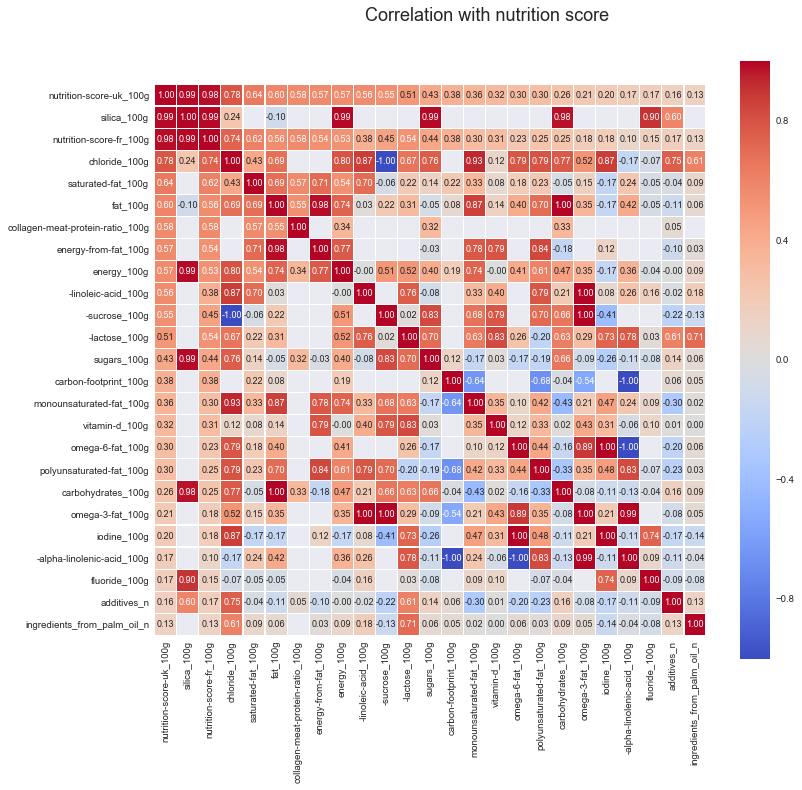

In [29]:
# heatmap of correlation with nutrition score
sns.set(context="paper", font_scale = 1.2)
corrmat = df_new.corr()
f, ax = plt.subplots(figsize=(11, 11))
cols = corrmat.nlargest(25, 'nutrition-score-uk_100g')['nutrition-score-uk_100g'].index
cm = corrmat.loc[cols, cols] 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation with nutrition score", ha='center', fontsize = 18)
plt.show()

In [30]:
df_new['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Beverages', 'Composite foods', 'Fish Meat Eggs', 'Fat and sauces',
       'Salty snacks', 'Cereals and potatoes', 'Milk and dairy products'], dtype=object)

In [31]:
categ_prod = [] ; label_prod = []
for i,s in enumerate(df_new['pnns_groups_1'].unique()):
    if isinstance(s, float): continue
    if s == 'unknown': continue    
    produit = str(s)
    df1 = df_new[df_new['pnns_groups_1'] == produit]
    table_1 = pd.Series(df1[pd.notnull(df1['nutrition-score-uk_100g'])]['nutrition-score-uk_100g'])
    categ_prod.append(table_1)
    label_prod.append(s)

In [32]:
table_1.head()

671      -1.0
719      20.0
733      19.0
1701      5.0
13659    22.0
Name: nutrition-score-uk_100g, dtype: float64

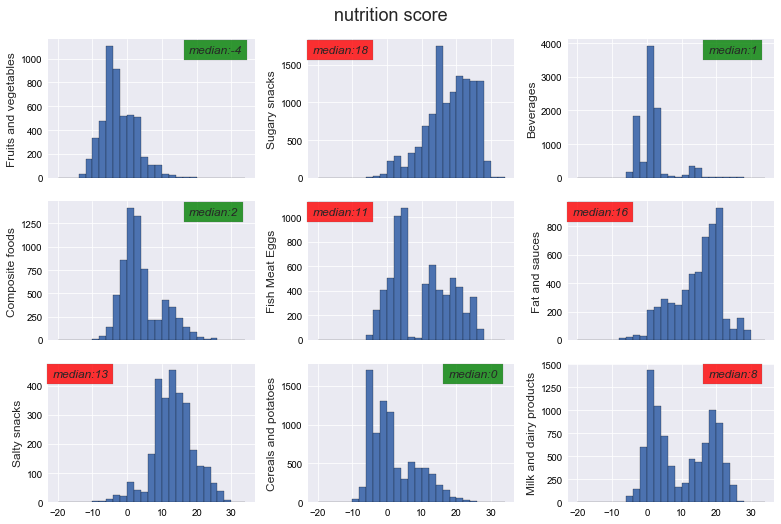

In [33]:
tPlot, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(11,7))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    t = categ_prod[i].value_counts(sort=True)
    t.sort_index(inplace=True)
    hist = list(t)
    bins = list(t.index)
    
    ax.tick_params(labelcolor='black', top='off', bottom='on', left='on', right='off')
    ax.set_ylabel(label_prod[i], fontsize = 12)
    ax.hist(categ_prod[i], bins=range(-20,36,2), edgecolor = 'k')

    mediane = int(categ_prod[i].median())
    color = 'green' if mediane <= 4 else 'red'
    if mediane < 11:
        ax.text(0.68, 0.9, 'median:{}'.format(int(categ_prod[i].median())), style='italic',
                transform=ax.transAxes, fontsize = 12,
                bbox={'facecolor':color, 'alpha':0.8, 'pad':5})
    else:
        ax.text(0.02, 0.9, 'median:{}'.format(int(categ_prod[i].median())), style='italic',
                transform=ax.transAxes, fontsize = 12,
                bbox={'facecolor':'red', 'alpha':0.8, 'pad':5})
    i += 1

tPlot.text(0.5, 1.01, 'nutrition score', ha='center', fontsize = 18)
plt.tight_layout()

Using the UK and France's nutrition scores, we can see that fruits, composite foods, and cereals and potatoes have the lowest median. The least healthy food was sugary snacks. Since that is the case, we'll be estimating the sugar content of foods.

In [34]:
def spider(values, cat, ax):
    N = len(cat)
    x_as = [n / float(N) * 2 * pi for n in range(N)]
    # for circularity
    values += values[:1]
    x_as += x_as[:1]
    # Set color of axes
    plt.rc('axes', linewidth=0.5, edgecolor="#888888")
    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Set position of y-labels
    ax.set_rlabel_position(0)
    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    # Set ticks values and labels    
    ax.set_xticks(x_as[:-1])
    ax.set_xticklabels([])
    ax.set_yticks([0.1, 0.5, 1, 2, 10])
    ax.set_yticklabels(["0.1", "0.5", "1", "2", "10"])
    # Plot data
    ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)
    # Fill area
    ax.fill(x_as, values, 'b', alpha=0.3)
    # Set axes limits
    ax.set_ylim(0, 3)
    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi
        if angle_rad == 0:
            ha, distance_ax = "center", 3
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 3
        elif angle_rad == pi:
            ha, distance_ax = "center", 3
        else:
            ha, distance_ax = "right", 3

        ax.text(angle_rad, 0.2+distance_ax, cat[i], size=10,
                horizontalalignment=ha, verticalalignment="center")

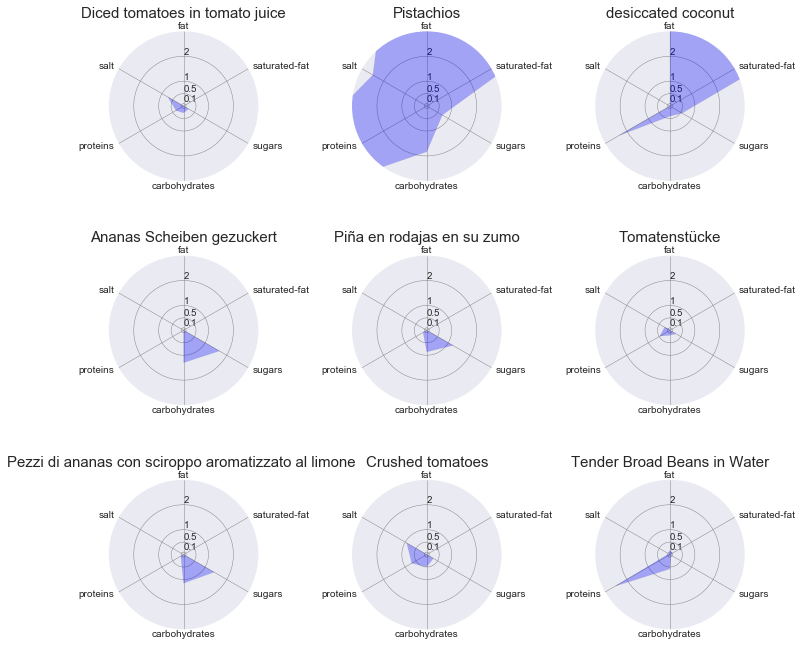

In [35]:
liste_columns = ['fat_100g', 'saturated-fat_100g', 'sugars_100g', 'carbohydrates_100g',
                'proteins_100g', 'salt_100g']

fruit_df = df_new[df_new["pnns_groups_1"] == "Fruits and vegetables"]
df_chart = fruit_df[pd.notnull(fruit_df[liste_columns]).all(axis = 1)]
mean_values = list(df_chart[liste_columns].mean().values)

fig, axes = plt.subplots(nrows=3, ncols=3, subplot_kw=dict(projection='polar'), figsize=(11,11))
axes = np.array(axes)

list_nutriments = [s.strip('_100g') for s in liste_columns]

ind = 0
for ax in axes.reshape(-1):
   ind += 1
   ind2 = 4*ind
   absolute_values = list(df_chart.iloc[ind2][liste_columns].T.values)
   values  = [ val/mean_values[i] for i, val in enumerate(absolute_values)]
   spider(values, list_nutriments, ax)
   ax.set_title(df_chart.iloc[ind2]['product_name'], fontsize = 15)
   
fig.subplots_adjust(hspace=0.5)
plt.show()

### Model Building

In [36]:
# Keep only consistent features (less of 60% NaN values)
de = df.isnull().mean(axis=0)
list1 = []
for i in range(0,len(de)):
    if de[i] < 0.6:
        templist = list(de[de==de[i]].index) 
        for i in range (0,len(templist)):
            list1.append(templist[i])

consistent_feature = list(set(list1)) 
df_newfeat = df.loc[:, lambda df: consistent_feature] 
df_newfeat.shape

(356027, 38)

In [37]:
# Remove unwanted features
NoList = ["code","url","states_en", "countries_tags","additives","brands",
          "last_modified_datetime","creator","additives_tags",
          "states","states_tags","ingredients_text","created_datetime",
          "serving_size","created_t","nutrition-score-uk_100g","countries",
          "last_modified_t","brands_tags","additives_en",
          "ingredients_that_may_be_from_palm_oil_n"]

for i in range (0,len(NoList)):
    consistent_feature.remove(NoList[i])

df_newfeat = df.loc[:, lambda df: consistent_feature]
df_newfeat.shape

(356027, 17)

In [38]:
list_temp = ["product_name","countries_en","nutrition_grade_fr","nutrition-score-fr_100g"]
featlist = list(df_newfeat)
for i in range(0,len(list_temp)):
    featlist.remove(list_temp[i])

# Replace NaN value by 0 for nuremic features.
for i in range(len(featlist)):
    df_newfeat[featlist[i]].fillna(0, inplace=True)
# Replace NaN value by Unknow for categorial features
df_newfeat["countries_en"].fillna("Unknow", inplace=True)
df_newfeat["product_name"].fillna("Unknow", inplace=True)


In [39]:
df_clean = df_newfeat.dropna(axis=0, how='any') 
df_clean = df_newfeat.sort_values(by=["nutrition_grade_fr"] , ascending=[True])
df_clean.shape

(356027, 17)

In [40]:
# making test / train
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lreg = LinearRegression()

Xtrain = df_clean.loc[:,['fiber_100g', 'proteins_100g', 'fat_100g', 'salt_100g', 'sodium_100g', 
                 'additives_n', 'carbohydrates_100g']]

Ytrain = df_clean.loc[:,'sugars_100g']

Xtest = df_clean.loc[:,['fiber_100g', 'proteins_100g', 'fat_100g', 'salt_100g', 'sodium_100g', 
                 'additives_n', 'carbohydrates_100g']]

Ytest = df_clean.loc[:,'sugars_100g']

x_train, x_test, y_train, y_test = train_test_split(Xtrain,Ytrain,test_size=0.2)

In [41]:
# defining rmsle function
def rmsle(y, yp): 
    """
    Compute the Root Mean Squared Log Error for hypothesis yp and targets y
    Args:
        yp - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log1p(yp) - np.log1p(y)).mean())

acc_scorer = make_scorer(score_func = rmsle, greater_is_better = False)

# defining rmsle
from sklearn.cross_validation import KFold
def cv_rmsle (k,model,Xtrain,Ytrain,**kwargs):
    error = []
    n = Xtrain.shape[0]
    kf = KFold(n, n_folds = k, shuffle=True)
    #loop through K fold
    for i, (train_index, test_index) in enumerate(kf):#get the train and test index generated by Kfold
        x_train = Xtrain.iloc[train_index] #xtrain for a fold
        y_train = Ytrain.iloc[train_index] #ytrain for a fold
        x_test = Xtrain.iloc[test_index]  #xtest for a fold
        y_test = Ytrain.iloc[test_index]  #ytest for a fold
        
        #predict and calculate rmsle
        __, pred_ytest = globals()[model](x_train,y_train,x_test,**kwargs)
        error.append(rmsle(y_test,pred_ytest))
        print("finish {} round of {}, rmlse = {}".format(i,model,rmsle(y_test,pred_ytest)))
    return error

/Users/anna_curology/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [42]:
# linear model
import statsmodels.api as sm

def linear_reg(x_train,y_train,x_test): 
    x = sm.add_constant(x_train, has_constant='add')
    est = sm.OLS(y_train, x)
    est = est.fit()
    lm_summary = est.summary()
    pred_x = sm.add_constant(x_test, has_constant='add')
    pred_y= est.predict(pred_x)
    return (lm_summary,pred_y)

In [43]:
lm_summary,pred_testy = linear_reg(x_train,y_train,x_test)

In [44]:
import sklearn
from sklearn import metrics
rmsle(y_test,pred_testy) # calculating rmsle

1.3953117297283271

In [45]:
lm_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sugars_100g   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                 2.581e+04
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:39:39   Log-Likelihood:            -1.1974e+06
No. Observations:              284821   AIC:                         2.395e+06
Df Residuals:                  284813   BIC:                         2.395e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9503      0.039    100.618      0.000       3.873       4.027
fiber_100g          3.342e-11   1.91e-10      0.175      0.861   -3.41e-10    4.08e-10
proteins_100g         -0.4082      0.002   -201.698      0.000      -0.412      -0.404
fat_100g              -0.0134      0.002     -7.176      0.000      -0.017      -0.010
salt_100g            -12.3659     30.726     -0.402      0.687     -72.587      47.856
sodium_100g           31.4092     78.043      0.402      0.687    -121.553     184.372
additives_n            0.3252      0.013     24.403      0.000       0.299       0.351
carbohydrates_100g     0.4216      0.001    402.735      0.000       0.420       0.424
==============================================================================
Omnibus:                   845519.604   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1079945196678.339
Skew:                          41.322   Prob(JB):                         0.00
Kurtosis:                    9542.029   Cond. No.                     4.39e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
lm_summary,pred_y = linear_reg(Xtrain,Ytrain,Xtest)
pred_y.head()

100999    7.531793
95548     8.696753
95557     9.382471
95574     7.377730
95580    -3.455300
dtype: float64

## Cross-Validation

Using Random Forest to cross-validate.

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:

def random_forest(x_train,y_train,x_test,**kwargs):
    forest = RandomForestRegressor(**kwargs)
    forest.fit(x_train, y_train)
    pred_y = forest.predict(x_test)
    return forest,pred_y

def plot_rf_importance(forest):
    imp = pd.DataFrame(forest.feature_importances_, columns = [ 'Importance' ], index = x_train.columns)
    
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 15].plot( kind = 'barh' )

In [49]:
acc_scorer = make_scorer(score_func = rmsle, greater_is_better = False)
model = RandomForestRegressor()
parameters = {'n_estimators': [100], 
              'max_features': ['log2', 'sqrt','auto'], #The number of features to consider when looking for the best split
              'max_depth': [5, 10,12], 
              'min_samples_split': [2, 3, 5],
             }
grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(x_train, y_train)
model_params = grid_obj.best_params_
model_params
grid_obj.best_score_

-0.7383591297318568

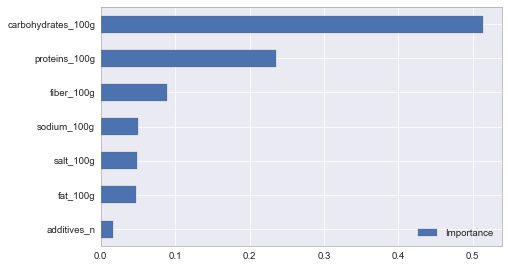

In [50]:
model_params = {'max_depth': 12,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 100}
forest, pred_testy = random_forest(x_train,y_train,x_test,**model_params)
rmsle(y_test,pred_testy)
plot_rf_importance(forest)

In [51]:
k = 5
model = "random_forest"
model_params = {'max_depth': 12,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 100}
rmsle_rf = cv_rmsle(k, model, Xtrain,Ytrain,**model_params)
rmsle_rf = np.mean(rmsle_rf)
rmsle_rf

finish 0 round of random_forest, rmlse = 0.7359678396048747
finish 1 round of random_forest, rmlse = 0.7355731469177007
finish 2 round of random_forest, rmlse = 0.7421243899309529
finish 3 round of random_forest, rmlse = 0.7252703225429958
finish 4 round of random_forest, rmlse = 0.738381784466989


0.73546349669270261

In [52]:
forest, pred_y = random_forest(Xtrain,Ytrain,Xtest,**model_params)
pred_y

array([ 1.49328849,  8.74500467,  7.20248271, ...,  0.20890997,
        0.20890997,  0.01801531])

## Conclusion

The lower the RMSLE the better, so in this case the Random Forest model showed a more accurate regression. This makes sense given the high degree of std. err in sodium_100g.

In any case, in examining the p-values of the linear model, foods high in carbs or additives and low in salt are potentially sugary foods to avoid!